In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import string
import emoji
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter 

In [2]:
file_path = r"C:\Users\Nathan\Documents\WGU\D604\Task 2\sentiment labelled sentences\imdb_labelled.txt"
df = pd.read_csv(file_path, sep="\t", header=None, names=["review", "label"])

In [3]:
sentences, labels = [], []
for _, row in df.iterrows():
    sentences.append(row['review'])
    labels.append(row['label'])
data = pd.DataFrame({'sentence': sentences, 'label': labels})

In [4]:
df['non_ascii'] = df['review'].apply(lambda x: bool(re.search(r'[^\x00-\x7F]', x)))
non_ascii_count = df['non_ascii'].sum()
print(f"Reviews with non-ASCII characters: {non_ascii_count} ({non_ascii_count/len(df)*100:.2f}%)")

Reviews with non-ASCII characters: 13 (1.74%)


In [5]:
df['has_emoji'] = df['review'].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x))
print(f"Reviews containing emojis: {df['has_emoji'].sum()}")

Reviews containing emojis: 0


In [6]:
df['has_html'] = df['review'].str.contains(r'<.*?>')
print(f"Reviews containing HTML tags: {df['has_html'].sum()}")

Reviews containing HTML tags: 0


In [7]:
all_text = " ".join(df['review'])
special_chars = re.findall(r'[^A-Za-z0-9\s]', all_text)
char_counts = Counter(special_chars)
print(char_counts.most_common(10))

[('.', 1047), (',', 649), ("'", 334), ('-', 170), ('!', 85), ('"', 74), (')', 56), ('(', 50), (':', 25), ('/', 20)]


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def find_unusual_characters(text):
    return re.findall(r'[^\x00-\x7F]+', text)
all_unusual_chars = data['sentence'].apply(find_unusual_characters).sum()
unusual_char_counts = Counter(all_unusual_chars)
print(unusual_char_counts)

Counter({'\x96': 5, 'é': 4, '\x85': 2, 'å': 1, '\x97': 1})


In [10]:
def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = text.lower()
    text = text.translate(str.maketrans('','', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text).strip()
    return text
data['cleaned_sentence'] = data['sentence'].apply(clean_text)

In [11]:
all_unusual_chars_cleaned = data['cleaned_sentence'].apply(find_unusual_characters).sum()
unusual_char_counts_cleaned = Counter(all_unusual_chars_cleaned)

print(unusual_char_counts_cleaned)

Counter()


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_sentence'])
vocab_size = len(tokenizer.word_index)
print("Vocabulary size:", vocab_size)

Vocabulary size: 3052


count    748.000000
mean      10.419786
std       38.526233
min        1.000000
25%        4.000000
50%        7.000000
75%       10.000000
max      789.000000
Name: review_length, dtype: float64
Recommended max sequence length (95th percentile): 19


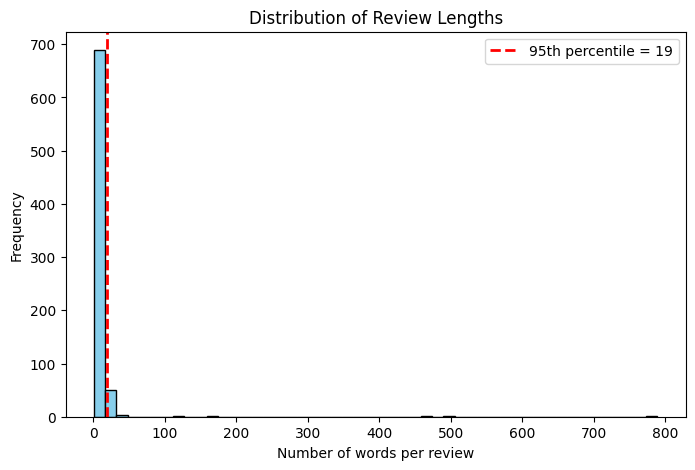

In [13]:
data['review_length'] = data['cleaned_sentence'].apply(lambda x: len(x.split()))

length_stats = data['review_length'].describe()
print(length_stats)

max_length = int(data['review_length'].quantile(0.95))
print(f"Recommended max sequence length (95th percentile): {max_length}")

plt.figure(figsize=(8,5))
plt.hist(data['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(max_length, color='red', linestyle='dashed', linewidth=2, label=f'95th percentile = {max_length}')
plt.xlabel("Number of words per review")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.legend()
plt.show()

In [14]:
sequences = tokenizer.texts_to_sequences(data['cleaned_sentence'])
max_sequence_length = 20
padded_sequences = pad_sequences(sequences, padding='post', maxlen=max_sequence_length)

print("Example of a single padded sequence:")
print(padded_sequences[0])

Example of a single padded sequence:
[1071 1072    1 1073 1074  294   69    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [15]:
labels = data['label'].values
X_train, X_train_val, y_train, y_train_val = train_test_split(padded_sequences, labels, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=1)

In [16]:
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 523
Validation size: 112
Test size: 113


In [25]:
prepared_data = data[['cleaned_sentence', 'label']]
prepared_data.to_csv(r'C:\Users\Nathan\Documents\WGU\D604\Task 2\cleaned_dataset.csv', index=False)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=100,
                    input_length=max_sequence_length))
model.add(SpatialDropout1D(0.3))  
model.add(Bidirectional(LSTM(units=128, return_sequences=False))) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4)) 
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

model.summary()

Epoch 1/20


C:\Users\Nathan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5048 - loss: 0.6943 - val_accuracy: 0.5357 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5602 - loss: 0.6853 - val_accuracy: 0.5268 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5927 - loss: 0.6805 - val_accuracy: 0.5982 - val_loss: 0.6817 - learning_rate: 0.0010
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7342 - loss: 0.6405 - val_accuracy: 0.6429 - val_loss: 0.6529 - learning_rate: 0.0010
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8528 - loss: 0.5158 - val_accuracy: 0.7679 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8642 - loss: 0.3529 - val_accuracy: 0.7321 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9197 - loss: 0.2422 - val_accuracy: 0.7143 - val_loss:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 100)             │         305,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,668,929 (6.37 MB)

 Trainable params: 556,309 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,112,620 (4.24 MB)

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7699 - loss: 0.5316 
Test Accuracy: 0.7699


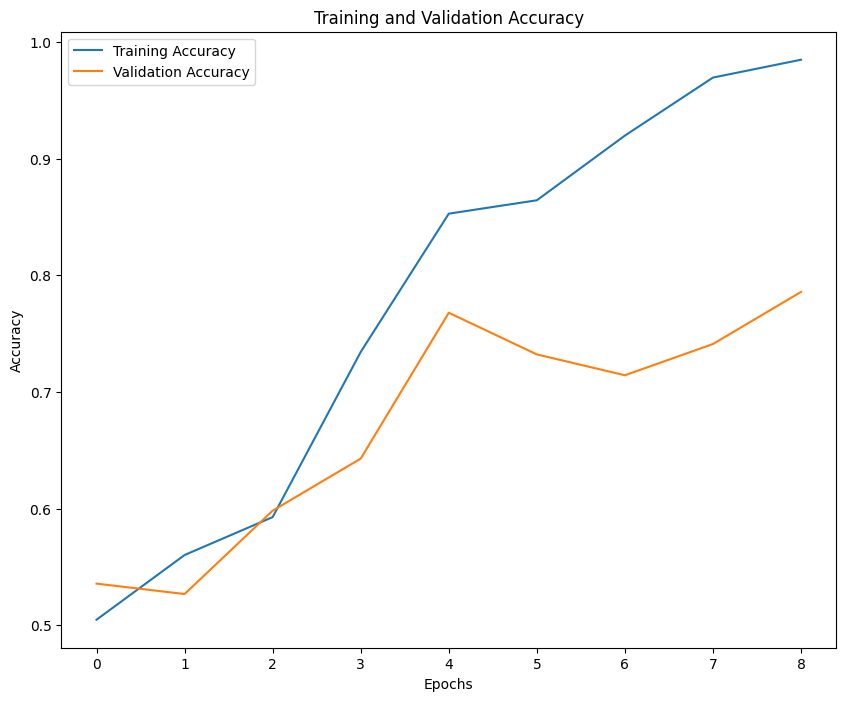

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

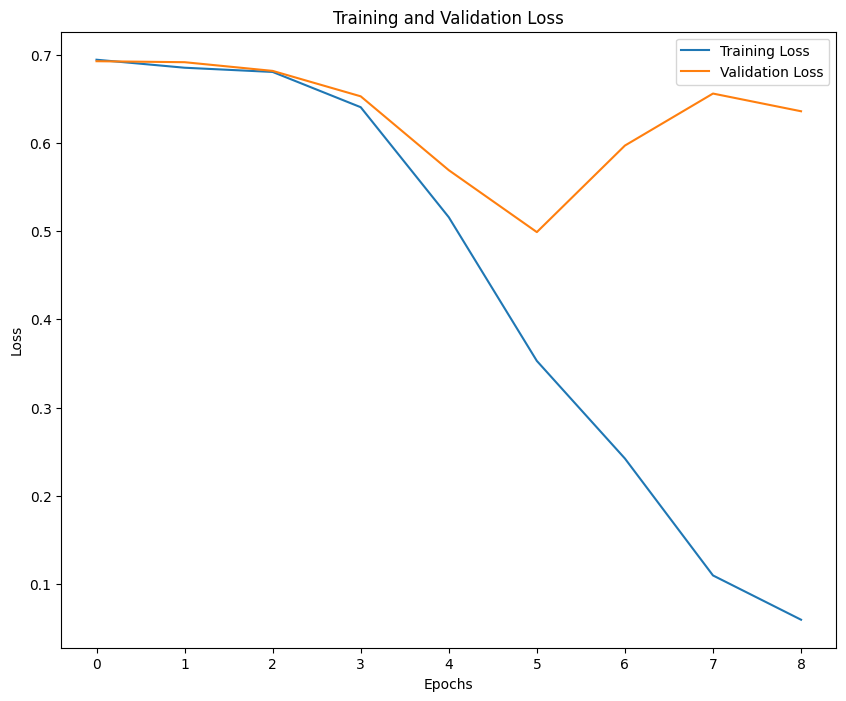

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
F1 Score: 0.7636


In [23]:
model.save(r"C:\Users\Nathan\Documents\WGU\D604\Task 2\sentiment_analysis_model.keras")